# Business and data understanding

## Purpose
This notebook contains the business and data understading phase for the Kaggle's competition [San Francisco Crime Classification](https://www.kaggle.com/competitions/sf-crime/).

## Methodology
- Simple data description;
- Data description using pandas-profiling.

## Results
*Working in progress*.

### TODOs:
- [ ] todo 1.

# Setup

## Library import

In [145]:
import os
from pathlib import Path

import folium
import humps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as ply

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Options for pandas and plotly
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 200
plotly.offline.init_notebook_mode(connected=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Local library import

In [4]:
if Path.cwd().name == 'notebooks':
    os.chdir('../')

from src.utils.data_describe import serie_nulos, cardinalidade

if Path.cwd().name == 'sf_crime':
    os.chdir('./notebooks/')

## Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [5]:
RAW_DATA = '../data/raw/' 
EXTERNAL_DATA = '../data/external/' 
INTERIM_DATA = '../data/interim/' 
PROCESSED_DATA = '../data/processed/'
REFERENCES = '../references/'

## Data import
We retrieve all the required data for the analysis.

In [6]:
try:
    df = pd.read_parquet(EXTERNAL_DATA + 'train.pqt')
    print('Parquet file loaded.')

except FileNotFoundError as e:
    df = pd.read_csv(
        EXTERNAL_DATA + 'train.csv',
        parse_dates=['Dates'],
        dtype={'X': float, 'Y': float}
    )
    df.to_parquet(EXTERNAL_DATA + 'train.pqt', index=False)
    print('CSV file loaded and parquet created.')

print(f'Dataset size: {df.shape}')

df.tail(3)

Parquet file loaded.
Dataset size: (878049, 9)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.394926,37.738212


# Data evaluation


## Null values and cardinality

In [137]:
df_evaluation = df.copy()

df_evaluation.columns = [humps.decamelize(x.strip()).lower() for x in df_evaluation.columns.tolist()]

df_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   dates        878049 non-null  datetime64[ns]
 1   category     878049 non-null  object        
 2   descript     878049 non-null  object        
 3   day_of_week  878049 non-null  object        
 4   pd_district  878049 non-null  object        
 5   resolution   878049 non-null  object        
 6   address      878049 non-null  object        
 7   x            878049 non-null  float64       
 8   y            878049 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB


In [138]:
cardinalidade(df_evaluation)

,Atributo,DType,Cardinalidade,Valores,Proporção Nulos
3,day_of_week,object,7,"[Friday, Monday, Saturday, Sunday, Thursday, Tuesday, Wednesday]",0.0
4,pd_district,object,10,"[BAYVIEW, CENTRAL, INGLESIDE, MISSION, NORTHERN, PARK, RICHMOND, SOUTHERN, TARAVAL, TENDERLOIN]",0.0
5,resolution,object,17,"[ARREST, BOOKED, ARREST, CITED, CLEARED-CONTACT JUVENILE FOR MORE INFO, COMPLAINANT REFUSES TO PROSECUTE, DISTRICT ATTORNEY REFUSES TO PROSECUTE, EXCEPTIONAL CLEARANCE, JUVENILE ADMONISHED, JUVENI...",0.0
1,category,object,39,"[ARSON, ASSAULT, BAD CHECKS, BRIBERY, BURGLARY, DISORDERLY CONDUCT, DRIVING UNDER THE INFLUENCE, DRUG/NARCOTIC, DRUNKENNESS, EMBEZZLEMENT, EXTORTION, FAMILY OFFENSES, FORGERY/COUNTERFEITING, FRAUD...",0.0
2,descript,object,879,"[ABANDONMENT OF CHILD, ABORTION, ACCESS CARD INFORMATION, PUBLICATION OF, ACCESS CARD INFORMATION, THEFT OF, ACCIDENTAL BURNS, ACCIDENTAL SHOOTING, ACTS AGAINST PUBLIC TRANSIT, ADVERTISING DISTRIB...",0.0
6,address,object,23228,"[0 Block of HARRISON ST, 0 Block of 10TH AV, 0 Block of 10TH ST, 0 Block of 11TH ST, 0 Block of 12TH AV, 0 Block of 12TH ST, 0 Block of 13TH ST, 0 Block of 14TH AV, 0 Block of 14TH ST, 0 Block of...",0.0
0,dates,datetime64[ns],389257,"[2003-01-06T00:01:00.000000000, 2003-01-06T00:15:00.000000000, 2003-01-06T00:20:00.000000000, 2003-01-06T00:31:00.000000000, 2003-01-06T00:33:00.000000000, 2003-01-06T00:40:00.000000000, 2003-01-0...",0.0


## Attribute 'Dates'

The 'Dates' attributes has information about date and time of the event. I will split it, therefore, it will be possible to analyze trends through the day and within a day.

In [140]:
if 'dates' in df_evaluation.columns:
    df_evaluation['dates_year'] = df_evaluation['dates'].dt.year
    df_evaluation['dates_month'] = df_evaluation['dates'].dt.month
    df_evaluation['dates_hour'] = df_evaluation['dates'].dt.time
    df_evaluation['dates_day'] = df_evaluation['dates'].dt.date
    df_evaluation = df_evaluation[[
        'dates_year', 'dates_month', 'dates_day', 'dates_hour', 'day_of_week',
        'category', 'descript', 'pd_district', 'resolution', 'address', 'x', 'y'
    ]]
else:
    pass

df_evaluation.head()

,dates_year,dates_month,dates_day,dates_hour,day_of_week,category,descript,pd_district,resolution,address,x,y
0,2015,5,2015-05-13,23:53:00,Wednesday,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015,5,2015-05-13,23:53:00,Wednesday,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015,5,2015-05-13,23:33:00,Wednesday,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015,5,2015-05-13,23:30:00,Wednesday,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015,5,2015-05-13,23:30:00,Wednesday,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


### Period of the occurences

In [127]:
df_date_agg = df_evaluation.groupby(by=['dates_year']).agg({'dates_day': 'nunique', 'descript': 'count', 'category': pd.Series.mode}).rename(
    columns={'dates_day': 'days_with_occurences', 'descript': 'qty_occurences', 'category': 'most_frequent'}).reset_index()

# df_date_agg['occurences_per_day'] #TODO: Verify the mean number of occurences per day.

df_date_agg

,dates_year,days_with_occurences,qty_occurences,most_frequent
0,2003,182,73902,LARCENY/THEFT
1,2004,182,73422,LARCENY/THEFT
2,2005,181,70779,LARCENY/THEFT
3,2006,183,69909,LARCENY/THEFT
4,2007,182,68015,LARCENY/THEFT
5,2008,182,70174,LARCENY/THEFT
6,2009,181,69000,LARCENY/THEFT
7,2010,180,66542,LARCENY/THEFT
8,2011,183,66619,LARCENY/THEFT
9,2012,183,71731,LARCENY/THEFT


## Attributes 'x' and 'y' (or longitude and latitude)

In [151]:
# Describing the 'x' and 'y' attributes:
df_evaluation[['x', 'y']].describe().T

,count,mean,std,min,25%,50%,75%,max
x,878049.0,-122.422616,0.030354,-122.513642,-122.432952,-122.416420,-122.406959,-120.5
y,878049.0,37.771020,0.456893,37.707879,37.752427,37.775421,37.784369,90.0


In [156]:
#Looking for a visual pattern in the registries with IMPOSSIBLE coordinates.
df_temp = df_evaluation.loc[(df_evaluation['x']>=-120.5) | (df_evaluation['y']>=90), :]

print(f'Registries with IMPOSSIBLE COORDINATES: {len(df_temp)}')

df_temp.groupby(by=['dates_year', 'pd_district', 'resolution', 'category']).agg({'dates_month': 'count'})

Registries with IMPOSSIBLE COORDINATES: 67


dates_month
dates_year pd_district resolution                       category                          
2003       BAYVIEW     COMPLAINANT REFUSES TO PROSECUTE ROBBERY                          1
                       NONE                             LARCENY/THEFT                    1
           INGLESIDE   ARREST, CITED                    OTHER OFFENSES                   2
           NORTHERN    ARREST, BOOKED                   STOLEN PROPERTY                  1
                                                        WARRANTS                         2
                       NONE                             LARCENY/THEFT                    1
           RICHMOND    NONE                             VEHICLE THEFT                    2
           SOUTHERN    ARREST, BOOKED                   WARRANTS                         1
                       COMPLAINANT REFUSES TO PROSECUTE SEX OFFENSES FORCIBLE            1
                       NONE                             LARCENY/THEFT                    2
2004       BAYVIEW     ARREST, CITED                    OTHER OFFENSES                   1
                       NONE                             SUSPICIOUS OCC                   1
           CENTRAL     NONE                             LARCENY/THEFT                    1
           INGLESIDE   JUVENILE BOOKED                  ASSAULT                          1
           MISSION     ARREST, CITED                    OTHER OFFENSES                   1
           NORTHERN    ARREST, BOOKED                   DISORDERLY CONDUCT               2
                                                        OTHER OFFENSES                   2
                                                        WARRANTS                         2
                       NONE                             LARCENY/THEFT                    1
           SOUTHERN    ARREST, CITED                    OTHER OFFENSES                   1
                       NONE                             LARCENY/THEFT                    1
                                                        VEHICLE THEFT                    1
2005       BAYVIEW     ARREST, BOOKED                   ASSAULT                          2
                                                        OTHER OFFENSES                   1
                       NONE                             BURGLARY                         1
                                                        VANDALISM                        1
           CENTRAL     NONE                             LARCENY/THEFT                    1
                                                        OTHER OFFENSES                   2
                                                        SUSPICIOUS OCC                   1
           INGLESIDE   NONE                             LARCENY/THEFT                    1
           NORTHERN    NONE                             OTHER OFFENSES                   1
           PARK        NONE                             VEHICLE THEFT                    2
           RICHMOND    ARREST, CITED                    OTHER OFFENSES                   1
                       NONE                             LARCENY/THEFT                    2
                                                        VEHICLE THEFT                    2
           SOUTHERN    NONE                             LARCENY/THEFT                    1
           TARAVAL     ARREST, BOOKED                   OTHER OFFENSES                   1
                                                        WARRANTS                         1
                       ARREST, CITED                    OTHER OFFENSES                   1
                       NONE                             LARCENY/THEFT                    1
           TENDERLOIN  ARREST, BOOKED                   OTHER OFFENSES                   1
                                                        TRESPASS                         1
                                                        WARRANTS           

**Attention!**

As it can be seen above, there is a pair of coordinates that DO NOT makes sense: (-120.5, 90.0). They appeared only in 2003, 2004 and 2005, and it does not seem to follow a pattern.

**Action:**

- At this moment, the action that will be taken is to use the mean for the set of 'dates_year', 'pd_district', 'resolution', 'category'.
- Another possibility is use the similarity among the address text and use the respectively coordinate.

### Transforming the coordinates outside SF area

In [158]:
df_evaluation['x'] = np.where((df_evaluation['x']>=-120.5), np.nan, df_evaluation['x'])
df_evaluation['y'] = np.where((df_evaluation['y']>=90), np.nan, df_evaluation['y'])

#TODO: Use the mean of each categories 'dates_year', 'pd_district', 'resolution', 'category' as the imputed number.
df_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dates_year   878049 non-null  int64  
 1   dates_month  878049 non-null  int64  
 2   dates_day    878049 non-null  object 
 3   dates_hour   878049 non-null  object 
 4   day_of_week  878049 non-null  object 
 5   category     878049 non-null  object 
 6   descript     878049 non-null  object 
 7   pd_district  878049 non-null  object 
 8   resolution   878049 non-null  object 
 9   address      878049 non-null  object 
 10  x            877982 non-null  float64
 11  y            877982 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 80.4+ MB


## Map

### How the crimes are distributed over a map?

In [85]:
df_evaluation.loc[
    (df_evaluation['address'].str.contains('OFARRELL'))
    & df_evaluation['address'].str.contains('5TH')
    , :]


,category,descript,day_of_week,pd_district,resolution,address,x,y,dates_year,dates_month,dates_hour,dates_day
660485,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5,90.0,2005,12,17:00:00,2005-12-30
673510,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Saturday,TENDERLOIN,NONE,OFARRELL ST / 5THSTNORTH ST,-120.5,90.0,2005,10,16:00:00,2005-10-22


In [86]:
df_evaluation.loc[
    (df_evaluation['address'].str.contains('OFARRELL')), :].head(2)


,category,descript,day_of_week,pd_district,resolution,address,x,y,dates_year,dates_month,dates_hour,dates_day
25,NON-CRIMINAL,LOST PROPERTY,Wednesday,TENDERLOIN,NONE,300 Block of OFARRELL ST,-122.41,37.79,2015,5,21:00:00,2015-05-13
194,LARCENY/THEFT,PETTY THEFT SHOPLIFTING,Wednesday,TENDERLOIN,"ARREST, BOOKED",0 Block of OFARRELL ST,-122.41,37.79,2015,5,14:15:00,2015-05-13


In [87]:
bbox = (round(df_evaluation['x'].quantile(.05), 1), round(df_evaluation['x'].quantile(.95), 1),
        round(df_evaluation['y'].quantile(.05), 1), round(df_evaluation['y'].quantile(.95), 1))

bbox

(-122.5, -122.4, 37.7, 37.8)

In [88]:
df_map = df_evaluation.loc[
    (df_evaluation['x'] > round(df_evaluation['x'].quantile(.005), 1))
    & (df_evaluation['x'] < round(df_evaluation['x'].quantile(.995), 1))
    & (df_evaluation['y'] > round(df_evaluation['y'].quantile(.005), 1))
    & (df_evaluation['y'] < round(df_evaluation['y'].quantile(.995), 1))
]

print(f"""df_evaluation: {len(df_evaluation)} registries
df_map: {len(df_map)} registries

{round(100 * ((len(df_evaluation) - len(df_map))/len(df_evaluation)), 1)}% of the registries have wrong coordinates (outside SF area).""")

df_evaluation: 878049 registries
df_map: 617598 registries

29.7% of the registries have wrong coordinates (outside SF area).


#### Using Map - 1st try

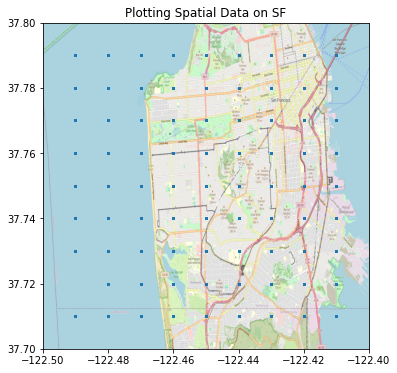

In [110]:
img = 'map_sf.png'

area_map = plt.imread(REFERENCES + img, )

fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(
    df_map['x'], df_map['y'],
#     zorder=1,
    alpha= 0.8, s=2)
ax.set_title('Plotting Spatial Data on SF')
ax.set_xlim(bbox[0], bbox[1])
ax.set_ylim(bbox[2], bbox[3])

ax.imshow(
    area_map, zorder=0, extent=bbox,
    aspect= 'equal'
);

#### Using Map - 2nd try

In [115]:
df_temp = df_evaluation.groupby(by=['pd_district', 'category', 'dates_year']).agg({'dates_day': 'count', 'x': 'mean', 'y': 'mean'}).reset_index()
df_temp.sort_values(by=['dates_day'], ascending=False)

,pd_district,category,dates_year,dates_day,x,y
3366,SOUTHERN,LARCENY/THEFT,2014,4961,-122.403068,37.780165
3365,SOUTHERN,LARCENY/THEFT,2013,4414,-122.403559,37.780150
3364,SOUTHERN,LARCENY/THEFT,2012,3826,-122.403147,37.780507
3358,SOUTHERN,LARCENY/THEFT,2006,3246,-122.403783,37.780459
3362,SOUTHERN,LARCENY/THEFT,2010,3155,-122.403490,37.780577
...,...,...,...,...,...,...
1665,MISSION,PORNOGRAPHY/OBSCENE MAT,2005,1,-122.410000,37.760000
3963,TARAVAL,SEX OFFENSES NON FORCIBLE,2004,1,-122.480000,37.760000
2865,RICHMOND,FAMILY OFFENSES,2012,1,-122.470000,37.780000
3436,SOUTHERN,PORNOGRAPHY/OBSCENE MAT,2013,1,-122.410000,37.770000


In [126]:
m = folium.Map(location=[37.75, -122.45], zoom_start=12, tiles= 'Stamen Toner')

folium.CircleMarker(
    location=[37.780165, -122.403068],
    radius=100,
    popup=f'SOUTHERN\nLARCENY/THEFT',
    color='blue',
    fill=True,
    fill_color='lightblue'
).add_to(m)

m


## Questions

### Which are the most frequent daytime period for each crime?

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2